# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

[nltk_data] Downloading package brown to
[nltk_data]     /Users/grigorijbelaev/nltk_data...
[nltk_data]   Package brown is already up-to-date!


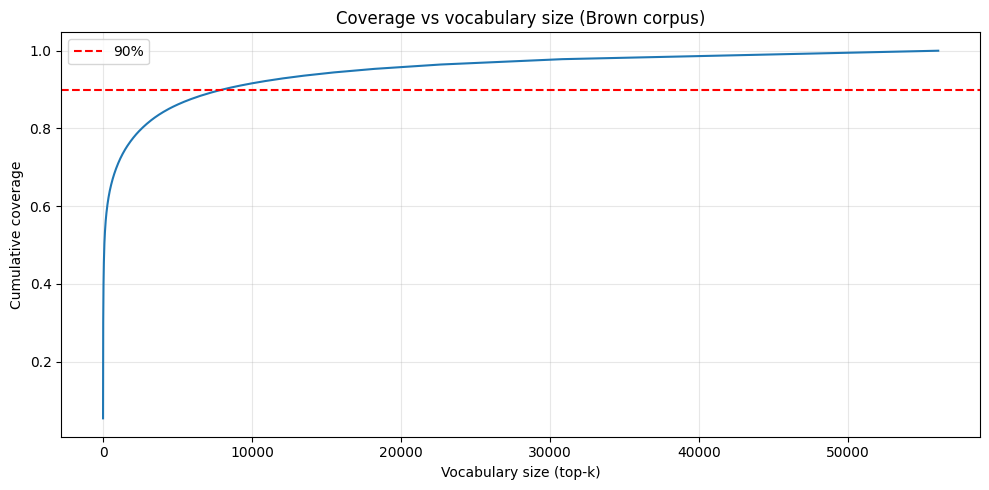

Минимальный размер словаря для 90% покрытия: 8012


In [4]:
import nltk
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

nltk.download("brown")
from nltk.corpus import brown

# корпус и частоты
words = brown.words()
freq = Counter(words)
total_tokens = sum(freq.values())
N = len(freq)

# по убыванию частоты ранг 1 топ
sorted_freq = sorted(freq.values(), reverse=True)
cumsum = np.cumsum(sorted_freq)
coverage = cumsum / total_tokens

# график
plt.figure(figsize=(10, 5))
plt.plot(range(1, N + 1), coverage)
plt.axhline(y=0.9, color="r", linestyle="--", label="90%")
plt.xlabel("Vocabulary size (top-k)")
plt.ylabel("Cumulative coverage")
plt.title("Coverage vs vocabulary size (Brown corpus)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# минимальный k для 90%
k_min = np.searchsorted(coverage, 0.9) + 1
print(f"Min vocabulary size for 90% coverage: {k_min}")

**Ответы:**

1. **Почему рост покрытия замедляется с ростом размера словаря?**  
   Самые частотные слова дают большой вклад в сумму частот; редкие слова (длинный хвост) имеют малые частоты. Добавление каждого следующего слова в словарь даёт всё меньший прирост покрытия.

2. **Какой эмпирический закон это объясняет?**  
   Закон Ципфа (Zipf's law): частота слова обратно пропорциональна его рангу. Из-за этого большая часть частот сосредоточена в топе, а хвост даёт малый прирост покрытия.

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [5]:
from collections import Counter
import time


class BPETokenizer:
    """BPE по корпусу учится потом режет текст на субтокены"""

    def __init__(self):
        self.vocab = {}
        self.merges = []  # пары по порядку слияния
        self._merge_ranks = {}  # ранг пары для tokenize

    def _get_pairs(self, word_freq):
        """пары с весами по частоте"""
        pairs = Counter()
        for word_tup, cnt in word_freq.items():
            for i in range(len(word_tup) - 1):
                pairs[(word_tup[i], word_tup[i + 1])] += cnt
        return pairs

    @staticmethod
    def _merge_in_tuple(word_tup, pair):
        """слить пару в кортеже за проход"""
        a, b = pair
        out = []
        i = 0
        while i < len(word_tup):
            if i < len(word_tup) - 1 and (word_tup[i], word_tup[i + 1]) == (a, b):
                out.append(a + b)
                i += 2
            else:
                out.append(word_tup[i])
                i += 1
        return tuple(out)

    def train(self, corpus, vocab_size, verbose=True):
        """обучение по корпусу строка или список слов vocab_size финальный размер словаря"""
        if isinstance(corpus, str):
            corpus = corpus.split()
        # типы слов с частотами быстрее чем миллион токенов
        word_freq = Counter(tuple([c for c in w] + ["</w>"]) for w in corpus)
        # стартовый словарь символы
        self.vocab = set()
        for w_tup in word_freq:
            self.vocab.update(w_tup)
        self.vocab = {t: i for i, t in enumerate(sorted(self.vocab))}
        self.merges = []
        target_merges = vocab_size - len(self.vocab)
        if target_merges <= 0:
            self._merge_ranks = {}
            return
        start = time.perf_counter()
        step = max(1, target_merges // 20)  # шлёшь в консоль раз в 20

        for step_num in range(target_merges):
            pairs = self._get_pairs(word_freq)
            if not pairs:
                break
            best = max(pairs, key=pairs.get)
            # заменяем пару везде в word_freq
            new_freq = Counter()
            for word_tup, cnt in word_freq.items():
                new_tup = self._merge_in_tuple(word_tup, best)
                new_freq[new_tup] += cnt
            word_freq = new_freq
            self.merges.append(best)
            new_tok = best[0] + best[1]
            if new_tok not in self.vocab:
                self.vocab[new_tok] = len(self.vocab)

            if verbose and ((step_num + 1) % step == 0 or step_num == 0):
                elapsed = time.perf_counter() - start
                done = step_num + 1
                eta = (elapsed / done) * (target_merges - done) if done else 0
                print(f"Merge {done}/{target_merges}  ({100*done/target_merges:.0f}%)  ETA: {eta:.0f}s")

        if verbose:
            print(f"Done in {time.perf_counter() - start:.1f}s")
        self._merge_ranks = {p: i for i, p in enumerate(self.merges)}

    def tokenize(self, text):
        """режет текст в список BPE токенов"""
        words = text.split()
        out = []
        for w in words:
            tokens = [c for c in w] + ["</w>"]
            for (a, b) in self.merges:
                i = 0
                new_tokens = []
                while i < len(tokens):
                    if i < len(tokens) - 1 and (tokens[i], tokens[i + 1]) == (a, b):
                        new_tokens.append(a + b)
                        i += 2
                    else:
                        new_tokens.append(tokens[i])
                        i += 1
                tokens = new_tokens
            out.extend(tokens)
        return out

## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [6]:
# треним на Brown k из таска 1
tokenizer = BPETokenizer()
tokenizer.train(list(brown.words()), vocab_size=k_min)

# тысяча предложений под метрики
sents = brown.sents()[:1000]
fertilities = []
lengths = []
for s in sents:
    text = " ".join(s)
    toks = tokenizer.tokenize(text)
    n_words = len(s)
    n_toks = len(toks)
    fertilities.append(n_toks / n_words if n_words else 0)
    lengths.append(n_toks)

print("Fertility (tokens per word): mean = {:.4f}, std = {:.4f}".format(np.mean(fertilities), np.std(fertilities)))
print("Tokenized sentence length: mean = {:.4f}, std = {:.4f}".format(np.mean(lengths), np.std(lengths)))

Merge 1/7928  (0%)  ETA: 1245s
Merge 396/7928  (5%)  ETA: 959s
Merge 792/7928  (10%)  ETA: 863s
Merge 1188/7928  (15%)  ETA: 794s
Merge 1584/7928  (20%)  ETA: 731s
Merge 1980/7928  (25%)  ETA: 675s
Merge 2376/7928  (30%)  ETA: 623s
Merge 2772/7928  (35%)  ETA: 572s
Merge 3168/7928  (40%)  ETA: 524s
Merge 3564/7928  (45%)  ETA: 476s
Merge 3960/7928  (50%)  ETA: 430s
Merge 4356/7928  (55%)  ETA: 384s
Merge 4752/7928  (60%)  ETA: 340s
Merge 5148/7928  (65%)  ETA: 295s
Merge 5544/7928  (70%)  ETA: 252s
Merge 5940/7928  (75%)  ETA: 209s
Merge 6336/7928  (80%)  ETA: 166s
Merge 6732/7928  (85%)  ETA: 124s
Merge 7128/7928  (90%)  ETA: 83s
Merge 7524/7928  (95%)  ETA: 42s
Merge 7920/7928  (100%)  ETA: 1s
Готово за 813.1 с
Fertility (токенов на слово): mean = 1.3165, std = 0.3060
Длина токенизированного предложения: mean = 27.9050, std = 15.3940


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later. 

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.